# Define the system  

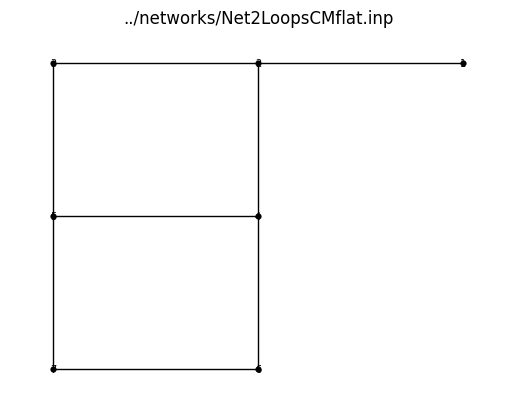

<Axes: title={'center': '../networks/Net2LoopsCMflat.inp'}>

In [142]:
import wntr
import wntr_quantum
import numpy as np
import os 

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# Create a water network model
# inp_file = '../networks/Net0.inp'
# inp_file = '../networks/Net2LoopsDW.inp'
inp_file = '../networks/Net2LoopsCMflat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


# Run with WNTR Simulator

In [143]:
inp_file = '../networks/Net2LoopsFlat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
sim = wntr.sim.WNTRSimulator(wn)
model, updater = wntr.sim.hydraulics.create_hydraulic_model(wn)

In [144]:
print(model.__str__())

cons:
mass_balance[2]:   (((expected_demand[2]-flow[1])+flow[2])+flow[3])
mass_balance[3]:   ((expected_demand[3]-flow[2])+flow[7])
mass_balance[4]:   (((expected_demand[4]-flow[3])+flow[4])+flow[5])
mass_balance[5]:   (((expected_demand[5]-flow[4])-flow[7])+flow[8])
mass_balance[6]:   ((expected_demand[6]-flow[5])+flow[6])
mass_balance[7]:   ((expected_demand[7]-flow[6])-flow[8])
approx_hazen_williams_headloss[1]:   (((((((-((sign(flow[1]))))*hw_resistance[1])*((abs(flow[1]))**1.852))-((1e-05*(hw_resistance[1]**0.5))*flow[1]))-(((sign(flow[1]))*minor_loss[1])*(flow[1]**2.0)))+source_head[1])-head[2])
approx_hazen_williams_headloss[2]:   (((((((-((sign(flow[2]))))*hw_resistance[2])*((abs(flow[2]))**1.852))-((1e-05*(hw_resistance[2]**0.5))*flow[2]))-(((sign(flow[2]))*minor_loss[2])*(flow[2]**2.0)))+head[2])-head[3])
approx_hazen_williams_headloss[3]:   (((((((-((sign(flow[3]))))*hw_resistance[3])*((abs(flow[3]))**1.852))-((1e-05*(hw_resistance[3]**0.5))*flow[3]))-(((sign(flow[3]))*minor

In [145]:
res = sim.run_sim()

In [146]:
res.link['flowrate']

,1,2,3,4,5,6,7,8
0,0.31109,0.051455,0.231865,0.031844,0.166691,0.075021,0.023685,-0.019471


In [147]:
res.node['pressure']

,2,3,4,5,6,7,1
0,203.24755,190.665142,199.321299,178.810032,195.547479,187.057524,0.0


## Run with the original Cholesky EPANET simulator

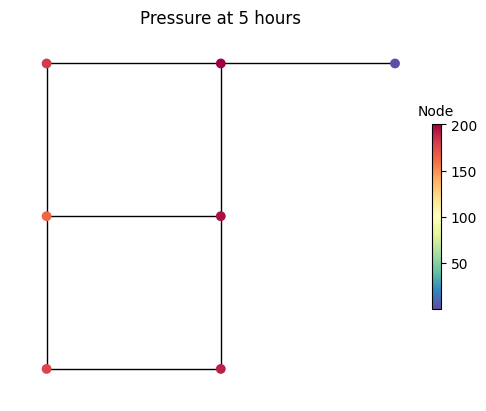

<Axes: title={'center': 'Pressure at 5 hours'}>

In [148]:
inp_file = '../networks/Net2LoopsCMflat.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
# sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [149]:
results.link["flowrate"]

name,1,2,3,4,5,6,7,8
0,0.31109,0.051113,0.232207,0.031075,0.167802,0.076132,0.023343,-0.020582


In [150]:
ref_pressure = results.node['pressure'].values[0][:-1]
ref_pressure

array([200.733, 181.735, 195.558, 163.834, 190.505, 177.75 ], dtype=float32)

In [96]:
results.node['pressure']

name,2,3,4,5,6,7,1
0,195.520416,165.836349,187.434158,137.866119,179.538773,159.609787,4.394531e-07


In [97]:
ref_rate = results.link['flowrate'].values[0]
ref_rate = ref_rate[[0,1,2,6,3,4,7,5]]

In [98]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.111e-02,  2.322e-01,  2.334e-02,  3.108e-02,  1.678e-01, -2.058e-02,  7.613e-02,  1.955e+02,  1.658e+02,  1.874e+02,  1.379e+02,  1.795e+02,  1.596e+02], dtype=float32)

## Run with the QUBO Polynomial Solver

In [99]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [100]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 9
step = (20/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=-10, var_base_name="x")

nqbit = 9
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+500.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 500.000000 => 700.000000 (res: 0.391389)
Flow Encoding : -10.000000 => 10.000000 (res: 0.039139)


In [101]:
net.convert_solution_from_si(ref_values)

array([ 10.986,   1.805,   8.2  ,   0.824,   1.097,   5.926,  -0.727,   2.689, 641.471, 544.083, 614.941, 452.317, 589.038, 523.654], dtype=float32)

Solve the system classically

In [107]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)
net.verify_solution(net.convert_solution_from_si(ref_values))

ref_sol = net.classical_solutions(max_iter = 100, tol= 1e-3)
ref_sol / ref_values

Warning, we didn't reach the required tolerance within 100 iterations, error is at 194.49915433794996


AssertionError: 

In [14]:
net.matrices[0]

array([[  0.981],
       [  0.981],
       [  1.177],
       [  2.649],
       [  3.237],
       [  1.962],
       [688.976],
       [  0.   ],
       [  0.   ],
       [  0.   ],
       [  0.   ],
       [  0.   ],
       [  0.   ],
       [  0.   ]])

In [108]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SteepestDescentSolver
from dwave.samplers import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model, strength=1E6, num_reads=10000, options={"sampler" : sampler, })
sol = net.extract_data_from_model(model)

In [109]:
net.convert_solution_from_si(sol)

array([  5.068,   4.403,   3.659,   5.108,   1.233,  -6.634,   1.82 ,   2.72 , 700.   , 700.   , 700.   , 500.   , 599.804, 500.   ])

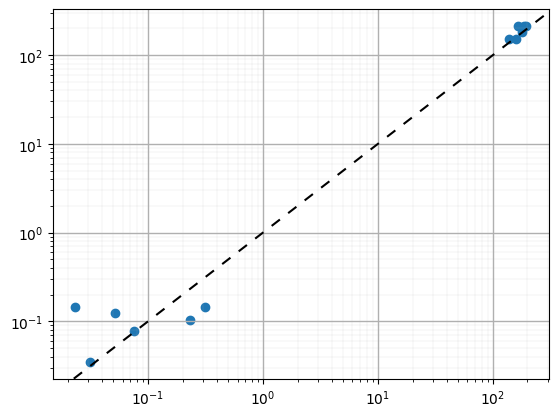

In [110]:
net.plot_solution_vs_reference(sol, ref_values)

In [43]:
net.diagnostic_solution(sol, ref_values)

Head Encoding : 500.000000 => 700.000000 (res: 0.391389)
Flow Encoding : -10.000000 => 10.000000 (res: 0.039139)


Error (%): [ 146.136  133.609    0.963  248.009  144.582 -213.716  278.043 -268.863   -9.124  -28.657  -16.952  -10.542   -4.745    4.517]


sol :  [-5.068e+00 -6.067e-01  8.121e+00 -1.624e+00 -2.642e+00  8.434e+00 -1.468e+00 -2.681e+00  7.000e+02  7.000e+02  7.000e+02  5.000e+02  5.998e+02  5.000e+02]
ref :  [ 10.986   1.805   8.2     1.097   5.926   2.689   0.824  -0.727 641.471 544.083 598.537 452.317 572.634 523.654]
diff:  [ 1.605e+01  2.412e+00  7.895e-02  2.722e+00  8.568e+00 -5.746e+00  2.292e+00  1.954e+00 -5.853e+01 -1.559e+02 -1.015e+02 -4.768e+01 -2.717e+01  2.365e+01]


encoded_sol:  [-5.068e+00 -6.067e-01  8.121e+00 -1.624e+00 -2.642e+00  8.434e+00 -1.468e+00 -2.681e+00  7.000e+02  7.000e+02  7.000e+02  5.000e+02  5.998e+02  5.000e+02]
encoded_ref:  [ 10.      1.82    8.2     1.115   5.93    2.681   0.841  -0.724 641.292 544.227 598.63  500.    572.798 523.48

# Run with the intergrated WNTR Solver

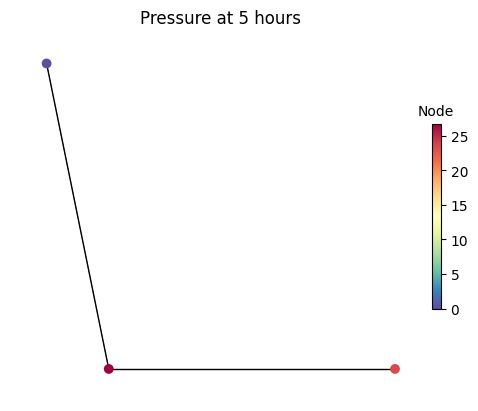

<Axes: title={'center': 'Pressure at 5 hours'}>

In [12]:
sim = wntr_quantum.sim.FullQuboPolynomialSimulator(wn, 
                                                   flow_encoding=flow_encoding, 
                                                   head_encoding=head_encoding)
results = sim.run_sim(solver_options={"sampler" : sampler})

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)